In [1]:
# Quantum Autoencoder for compression of Quantum Data

from matplotlib import pyplot as plt
from math import pi
import pennylane as qml
from pennylane import numpy as np
from qiskit.quantum_info import DensityMatrix
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers import backend
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.providers.aer import QasmSimulator
import math
# Initialize random seed
rng = np.random.default_rng(324)
# This is the number of input qubits
no_of_qubits = 5
#This is the number of ancilla qubits
aux_qubits = 2
# The code compresses no_of_qubits ---> (no_of_qubits-aux_qubits)

# initialzing random parameters
nparams = 2*(no_of_qubits*(no_of_qubits-1)+2*no_of_qubits)

training_params = 2*math.pi*rng.random((1,nparams))
training_params = training_params[0]

# initial state preparation
# initializes all input qubits to |1>, ancillas are default to |0>
dev2 = qml.device("default.qubit", wires=no_of_qubits+aux_qubits)
@qml.qnode(dev2,diff_method="backprop")
def init_circuit():
    for i in range(no_of_qubits):
        qml.PauliX(wires=i+aux_qubits)
    s= qml.state()
    return s

# in_state = Statevector(init_circuit())
# in_state.draw('qsphere')

In [ ]:
# This is the main parametrized circuit to be trained
dev1 = qml.device("default.qubit", wires=no_of_qubits+aux_qubits)

@qml.qnode(dev1,diff_method="backprop")
def circuit(training_params):
    
    # insert the RX, RZ, CRX, CRZ gates; this is the encoder part
    ctheta = 0
    for i in range(no_of_qubits):
        qml.PauliX(wires=i+aux_qubits)
    for i in range(no_of_qubits):
        qml.RX(training_params[ctheta],wires=i+aux_qubits)
        ctheta = ctheta+1
        qml.RZ(training_params[ctheta],wires=i+aux_qubits)
        ctheta = ctheta+1
    for i in range(no_of_qubits):
        for j in range(no_of_qubits):
            if i!=j:
                qml.CRX(training_params[ctheta],wires=[i+aux_qubits,j+aux_qubits])
                ctheta = ctheta+1
                qml.CRZ(training_params[ctheta],wires=[i+aux_qubits,j+aux_qubits])
                ctheta = ctheta+1
    for i in range(no_of_qubits):
        qml.RX(training_params[ctheta],wires=i+aux_qubits)
        ctheta = ctheta+1
        qml.RZ(training_params[ctheta],wires=i+aux_qubits)
        ctheta = ctheta+1
    # Swap systems B and B'
    for i in range(aux_qubits):
        qml.SWAP(wires=[i,i+aux_qubits])
    # insert the conjugate transpose; this is the decoder part
    ctheta = 0
    for i in range(no_of_qubits):
        qml.RX(-training_params[ctheta],wires=i+aux_qubits)
        ctheta = ctheta+1
        qml.RZ(-training_params[ctheta],wires=i+aux_qubits)
        ctheta = ctheta+1
    for i in range(no_of_qubits):
        for j in range(no_of_qubits):
            if i!=j:
                qml.CRX(-training_params[ctheta],wires=[i+aux_qubits,j+aux_qubits])
                ctheta = ctheta+1
                qml.CRZ(-training_params[ctheta],wires=[i+aux_qubits,j+aux_qubits])
                ctheta = ctheta+1
    for i in range(no_of_qubits):
        qml.RX(-training_params[ctheta],wires=i+aux_qubits)
        ctheta = ctheta+1
        qml.RZ(-training_params[ctheta],wires=i+aux_qubits)
        ctheta = ctheta+1

    s = qml.state()
    return s
# this is the cost function f=log(1-F); F being the fidelty between input and output
def cost(training_params):

    X = init_circuit().numpy()

    if isinstance(circuit(training_params), qml.numpy.tensor):
        Y = circuit(training_params).numpy()
    else:
        Y = circuit(training_params)._value
 
    return math.log(1-abs(np.vdot(X, Y))**2,10)

# initialise the optimizer
# opt = qml.GradientDescentOptimizer(stepsize=0.2)
# opt = qml.AdamOptimizer(stepsize=0.4, beta1=0.9, beta2=0.99, eps=1e-10)
# opt = qml.AdagradOptimizer(stepsize=0.2, eps=1e-08)
opt = qml.optimize.RotosolveOptimizer()

# set the number of steps
steps = 100
# run the optimizer
for i in range(steps):
    # update the circuit parameters
    training_params = opt.step(cost, training_params)
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(training_params)))

Cost after step     5: -0.6458421


In [38]:
training_params

array([ 0.07689827,  4.63177442,  4.55684637,  3.35322611,  1.69012804,
        1.8561345 ,  7.15954575, -0.39888896,  2.10002168,  3.16814288,
       -0.21359886,  1.03209226,  2.54079041,  5.87905711,  4.19930095,
        3.4588705 ,  3.9105843 ,  3.13185211, -0.10060596,  5.29031329,
        3.02628184,  1.33031201,  4.48604283,  2.79060769,  3.47948099,
        1.6808305 ,  0.22435281,  1.82753898,  3.09996599,  1.26346069,
        4.35344313,  2.29689616,  2.67428601,  6.92256641,  0.28517779,
        2.08347304,  2.68915219,  6.2541903 ,  0.55349574,  4.51791835,
        3.47257864,  4.35934498,  0.3715477 ,  2.55465557, -0.69844256,
        1.3069818 ,  0.71165069,  2.02707617,  0.08435614,  1.01005687,
        3.37173371, 42.40020563,  1.50891013, 52.74197072,  4.43757249,
        5.77729158,  0.14580114,  2.90280075, -0.13489348,  6.01700139])

In [39]:
# with the trained parameters, produce the compressed state

dev3 = qml.device("default.qubit", wires=no_of_qubits)
@qml.qnode(dev3,diff_method="backprop")
def trained_circuit(training_params):
    ctheta = 0
    for i in range(no_of_qubits):
        qml.PauliX(wires=i)
    for i in range(no_of_qubits):
        qml.RX(training_params[ctheta],wires=i)
        ctheta = ctheta+1
        qml.RZ(training_params[ctheta],wires=i)
        ctheta = ctheta+1
    for i in range(no_of_qubits):
        for j in range(no_of_qubits):
            if i!=j:
                qml.CRX(training_params[ctheta],wires=[i,j])
                ctheta = ctheta+1
                qml.CRZ(training_params[ctheta],wires=[i,j])
                ctheta = ctheta+1
    for i in range(no_of_qubits):
        qml.RX(training_params[ctheta],wires=i)
        ctheta = ctheta+1
        qml.RZ(training_params[ctheta],wires=i)
        ctheta = ctheta+1
    s = qml.state()
    return s

In [40]:
vec=trained_circuit(training_params)

In [41]:
s2=Statevector(vec)
traced_state = qiskit.quantum_info.partial_trace(s2,[x for x in range(aux_qubits)])
print(traced_state)

DensityMatrix([[ 5.08269928e-01+0.00000000e+00j,
                -9.25042570e-02+1.57903100e-01j,
                -8.85702999e-03+2.49128501e-03j,
                 3.83954468e-02+1.22444502e-02j,
                -8.79402319e-03-1.44188875e-02j,
                -3.73842441e-03+9.53307292e-03j,
                 1.56605243e-03+3.80809376e-05j,
                -7.73761783e-03-3.85779131e-04j],
               [-9.25042570e-02-1.57903100e-01j,
                 4.78824294e-01+0.00000000e+00j,
                 1.06170685e-02-5.20037895e-03j,
                 7.46326834e-03-2.80796722e-03j,
                -2.37960816e-03+7.50963047e-03j,
                -2.59932083e-03-1.68848165e-02j,
                -6.21770638e-03+7.70362237e-03j,
                -1.28442282e-03-1.70306671e-03j],
               [-8.85702999e-03-2.49128501e-03j,
                 1.06170685e-02+5.20037895e-03j,
                 3.84506084e-03+0.00000000e+00j,
                 2.69772226e-04+1.93966774e-03j,
                 8

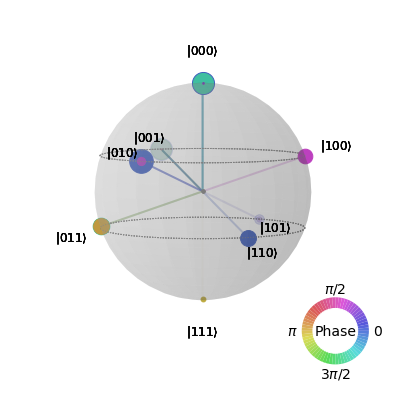

In [42]:
traced_state.draw('qsphere')